In [3]:
import glob
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.display import display
from skforecast.plot import set_dark_theme
from tqdm import tqdm

import sklearn
import skforecast
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from skforecast.recursive import ForecasterRecursive, ForecasterRecursiveMultiSeries
from skforecast.model_selection import (
    TimeSeriesFold,
    OneStepAheadFold,
    backtesting_forecaster,
    bayesian_search_forecaster,
    backtesting_forecaster_multiseries,
    bayesian_search_forecaster_multiseries
)
from skforecast.preprocessing import RollingFeatures, series_long_to_dict, exog_long_to_dict
from skforecast.exceptions import OneStepAheadValidationWarning

import warnings

warnings.filterwarnings("ignore", category=ResourceWarning)

colourOrangeBold = "\033[1m\033[38;5;208m"
colourReset = "\033[0m"

print(f"{colourOrangeBold}Version skforecast: {skforecast.__version__}{colourReset}")
print(f"{colourOrangeBold}Version scikit-learn: {sklearn.__version__}{colourReset}")
print(f"{colourOrangeBold}Version pandas: {pd.__version__}{colourReset}")
print(f"{colourOrangeBold}Version numpy: {np.__version__}{colourReset}")

import os
from pathlib import Path

project_root = Path().resolve()
while project_root.name != "Algothon-2025" and project_root != project_root.parent:
    project_root = project_root.parent

os.chdir(project_root)
print("Working directory set to:", os.getcwd())

set_dark_theme()

Version skforecast: 0.16.0
Version scikit-learn: 1.6.1
Version pandas: 2.2.3
Version numpy: 2.2.5
Working directory set to: C:\Users\jense\IdeaProjects\Algothon-2025


Set Training, Cross Validation and Testing Splits

In [4]:
TRAIN_START = 20
TRAIN_END = 600
VAL_END = 675

Import our price data: Prices are what we are predicting

In [5]:
# PRICES DATA:
data = pd.read_csv("./sourceCode/prices.txt", sep=r'\s+', header=None)
print(f"{colourOrangeBold}Shape: {data.shape}{colourReset}")

Shape: (750, 50)


Add column names to prices data

In [6]:
data.index.name = 'day'
data.columns = [f"inst_{i}" for i in range(data.shape[1])]

Split data into correct splits

In [7]:
# DATA SPLITTING:
data_train = data.loc[TRAIN_START:TRAIN_END - 1].copy()
data_val   = data.loc[TRAIN_END:VAL_END - 1].copy()
data_test  = data.loc[VAL_END:].copy()

print(f"Train days      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation days : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test days       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train days      : 20 --- 599  (n=580)
Validation days : 600 --- 674  (n=75)
Test days       : 675 --- 749  (n=75)


Plot prices data for a few instruments for fun

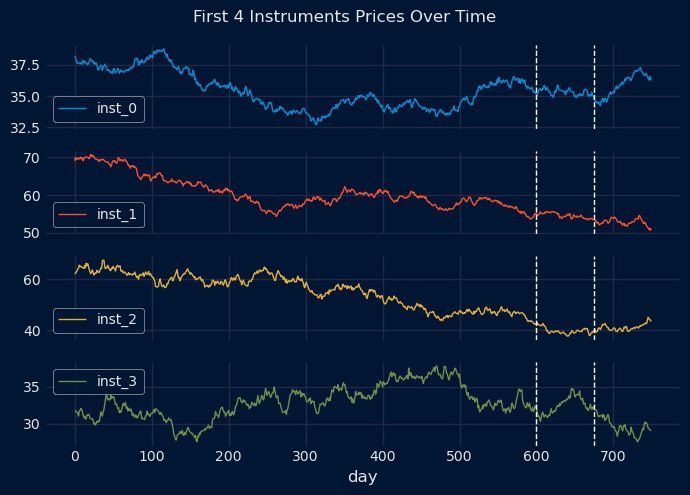

In [8]:
instrumentCount = 4

fig, axs = plt.subplots(instrumentCount, 1, figsize=(7, 5), sharex=True)
data.iloc[:, :instrumentCount].plot(
    legend=True,
    subplots=True,
    title='First 4 Instruments Prices Over Time',
    ax=axs,
    linewidth=1
)
# Add vertical lines at training and validation split
for ax in axs:
    ax.axvline(x=TRAIN_END, color='white', linestyle='--', linewidth=1)
    ax.axvline(x=VAL_END, color='white', linestyle='--', linewidth=1)
fig.tight_layout()
plt.show()

Train a forecaster that predicts prices for individual instruments for a baseline reference.

In [9]:
items = []
mse_values = []
predictions = {}

for i, item in enumerate(tqdm(data.columns)):
    # Define forecaster
    window_features = RollingFeatures(stats=['mean', 'min', 'max'], window_sizes=7)

    forecaster = ForecasterRecursive(
        regressor=HistGradientBoostingRegressor(random_state=8523),
        lags=20,
        window_features=window_features
    )

    # Backtesting forecaster
    cv = TimeSeriesFold(
        steps=1,
        initial_train_size=len(data_train) + len(data_val),
        refit=False,
    )

    metric, preds = backtesting_forecaster(
        forecaster=forecaster,
        y=data[item],
        cv=cv,
        metric='mean_squared_error',
        show_progress=False
    )

    items.append(item)
    mse_values.append(metric.at[0, 'mean_squared_error'])
    predictions[item] = preds

# Results
uni_series_mse = pd.Series(
    data=mse_values,
    index=items,
    name='uni_series_mse'
)

print(f"{colourOrangeBold}========================{colourReset}")
print(uni_series_mse.head())
print(f"{colourOrangeBold}========================{colourReset}\n\n")


100%|██████████| 50/50 [00:58<00:00,  1.17s/it]

inst_0     0.076080
inst_1     2.329248
inst_2     1.341477
inst_3     0.198996
inst_4    37.198736
Name: uni_series_mse, dtype: float64




Train a global / multi time series predictor that takes into account instrument correlation (Evaluated with the same backtester as the single instrument predictor):

In [10]:
items = list(data.columns)

# Define forecaster
window_features = RollingFeatures(stats=['mean', 'min', 'max'], window_sizes=14)
forecaster_ms = ForecasterRecursiveMultiSeries(
    regressor           =GradientBoostingRegressor(random_state=8523), # ~ 20 seconds
    # regressor           =HistGradientBoostingRegressor(random_state=8523), # Much quicker, slightly less accurate, nan safe
    lags                =20,
    encoding            ='ordinal',
    transformer_series  =StandardScaler(),
    window_features     =window_features,
)

# Backtesting forecaster for all items
cv = TimeSeriesFold(
    initial_train_size  =len(data_train) + len(data_val),
    steps               =1,   # Predict 7 steps ahead
    refit               =True # Retrain at each split
)

multi_series_mse, predictions_ms = backtesting_forecaster_multiseries(
    forecaster          =forecaster_ms,
    series              =data,
    levels              =items,
    cv                  =cv,
    metric              ='mean_squared_error',
)

# Results
display(multi_series_mse.head(5))
display(predictions_ms.head(5))

predictions_ms = predictions_ms.reset_index()

╭──────────────────────────────── LongTrainingWarning ─────────────────────────────────╮
│ The forecaster will be fit 95 times. This can take substantial amounts of time. If   │
│ not feasible, try with `refit = False`.                                              │
│                                                                                      │
│                                                                                      │
│ Category : LongTrainingWarning                                                       │
│ Location :                                                                           │
│ C:\Users\jense\anaconda3\envs\Algothon-2025\Lib\site-packages\skforecast\model_selec │
│ tion\_validation.py:844                                                              │
│ Suppress : warnings.simplefilter('ignore', category=LongTrainingWarning)             │
╰──────────────────────────────────────────────────────────────────────────────────────╯

  0%|          | 0/95 [00:00<?, ?it/s]

,levels,mean_squared_error
0,inst_0,0.025110
1,inst_1,0.113170
2,inst_2,0.254505
3,inst_3,0.123343
4,inst_4,0.141662


,level,pred
655,inst_0,35.017062
655,inst_1,54.346196
655,inst_2,40.058624
655,inst_3,34.021163
655,inst_4,46.178838


Compare the global to unique predictors:

In [11]:
multi_series_mse = multi_series_mse.set_index('levels')
multi_series_mse.columns = ['multi_series_mse']

results = pd.concat((uni_series_mse, multi_series_mse), axis=1)
results['improvement'] = results.eval('uni_series_mse - multi_series_mse')
results['improvement_(%)'] = 100 * results.eval('(uni_series_mse - multi_series_mse) / uni_series_mse')
results = results.round(2)

display(results.style.bar(subset=['improvement_(%)'], align='mid', color=['#d65f5f', '#5fba7d']))
display(results[['improvement', 'improvement_(%)']].agg(['mean', 'min', 'max']))


,uni_series_mse,multi_series_mse,improvement,improvement_(%)
inst_0,0.080000,0.030000,0.050000,67.000000
inst_1,2.330000,0.110000,2.220000,95.140000
inst_2,1.340000,0.250000,1.090000,81.030000
inst_3,0.200000,0.120000,0.080000,38.020000
inst_4,37.200000,0.140000,37.060000,99.620000
inst_5,0.040000,0.030000,0.010000,26.690000
inst_6,0.230000,0.060000,0.170000,73.950000
inst_7,0.730000,0.360000,0.360000,50.150000
inst_8,0.280000,0.270000,0.010000,2.800000
inst_9,2.510000,0.480000,2.030000,80.830000


,improvement,improvement_(%)
mean,1.8106,59.2508
min,0.0100,2.8000
max,37.0600,99.6200


Using global predict:

,time,level,pred,actual
0,655,inst_0,35.017062,35.10
1,656,inst_0,35.095640,35.20
2,657,inst_0,35.212525,35.04
3,658,inst_0,35.031688,35.14
4,659,inst_0,35.146568,35.05
...,...,...,...,...
90,745,inst_0,36.494485,36.49
91,746,inst_0,36.490672,36.30
92,747,inst_0,36.286882,36.58
93,748,inst_0,36.583518,36.43


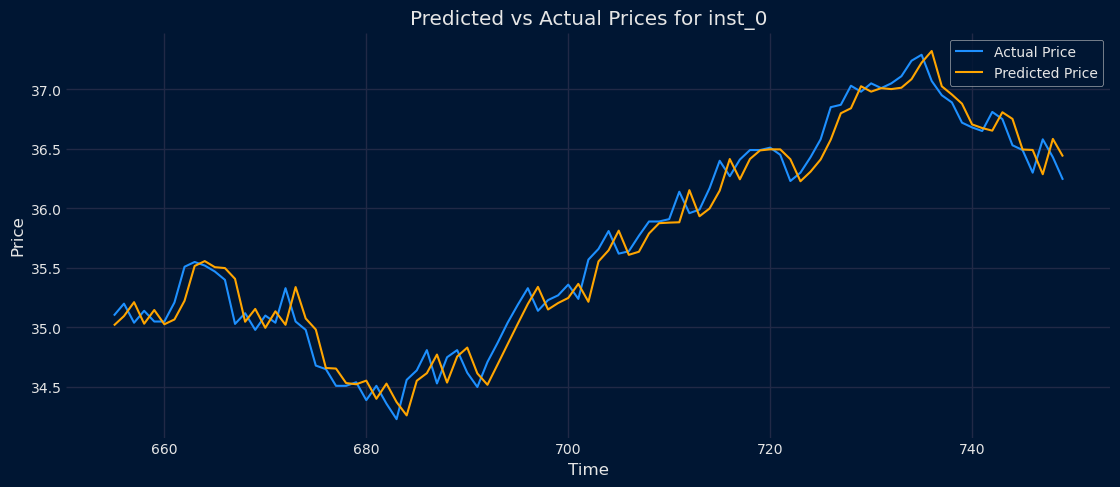

In [12]:
def plotPredictedVsActual(predictions_input, instrument):
    df_preds = predictions_input.copy().rename(columns={"index": "time"})
    df_inst_preds = df_preds[df_preds["level"] == instrument]
    days_predicted = df_inst_preds["time"]
    df_actual = data[[instrument]].copy()
    df_actual["time"] = df_actual.index
    df_actual = df_actual.rename(columns={instrument: "actual"})
    df_actual = df_actual[df_actual["time"].isin(days_predicted)]
    df_plot = df_inst_preds.merge(df_actual, on="time")
    display(df_plot)
    # Step 4: Plot
    plt.figure(figsize=(12, 5))
    plt.plot(df_plot["time"], df_plot["actual"], label="Actual Price", color='dodgerblue')
    plt.plot(df_plot["time"], df_plot["pred"], label="Predicted Price", color='orange')
    plt.title(f"Predicted vs Actual Prices for {instrument}")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


plotPredictedVsActual(predictions_ms, "inst_0")


Above looks decent but also a bit shite

**Now going to try adding more greeks to use in the model as exogenous features**


In [13]:
# Get exog features in a dictionary
greeksFilePaths = sorted(glob.glob("./greeks/greeksData/*.npy"))
feature_names = [os.path.splitext(os.path.basename(f))[0] for f in greeksFilePaths]

exog_array = np.stack([np.load(f) for f in greeksFilePaths], axis=-1)

exog_dict = {
    f"inst_{i}": pd.DataFrame(exog_array[:, i, :], columns=feature_names)
    for i in range(exog_array.shape[1])
}

print(f"{colourOrangeBold}Built exog_dict with {len(exog_dict)} instruments, each shape {exog_dict['inst_0'].shape}{colourReset}")
print("Features:", feature_names)

Built exog_dict with 50 instruments, each shape (750, 8)
Features: ['LogReturns_lookback=1_750_day_data', 'LogReturns_lookback=3_750_day_data', 'Momentum_windowSize=14_750_day_data', 'Momentum_windowSize=3_750_day_data', 'Momentum_windowSize=7_750_day_data', 'Volatility_windowSize=10_750_day_data', 'Volatility_windowSize=20_750_day_data', 'Volatility_windowSize=5_750_day_data']


Create our forecaster including these exogenous features


In [14]:
forecaster_ms_greeks = ForecasterRecursiveMultiSeries(
    regressor           = GradientBoostingRegressor(random_state=8523),
    lags                = 20,
    transformer_series  = StandardScaler(),
    transformer_exog    = StandardScaler(),  # Standardise the Greek features
)

cv = TimeSeriesFold(
    initial_train_size = len(data_train) + len(data_val),
    steps              = 1,
    refit              = True
)

# Backtest
multi_series_mse_greeks, predictions_ms_greeks = backtesting_forecaster_multiseries(
    forecaster = forecaster_ms_greeks,
    series     = data,
    exog       = exog_dict,
    levels     = list(data.columns),
    cv         = cv,
    metric     = "mean_squared_error"
)

display(multi_series_mse_greeks.head())
display(predictions_ms_greeks.head())

multi_series_mse_greeks = multi_series_mse_greeks.rename(columns={"mean_squared_error": "multi_series_mse_greeks"})
predictions_ms_greeks = predictions_ms_greeks.reset_index()
predictions_ms_greeks = predictions_ms_greeks.rename(columns={"index": "time"})

╭──────────────────────────────── LongTrainingWarning ─────────────────────────────────╮
│ The forecaster will be fit 95 times. This can take substantial amounts of time. If   │
│ not feasible, try with `refit = False`.                                              │
│                                                                                      │
│                                                                                      │
│ Category : LongTrainingWarning                                                       │
│ Location :                                                                           │
│ C:\Users\jense\anaconda3\envs\Algothon-2025\Lib\site-packages\skforecast\model_selec │
│ tion\_validation.py:844                                                              │
│ Suppress : warnings.simplefilter('ignore', category=LongTrainingWarning)             │
╰──────────────────────────────────────────────────────────────────────────────────────╯

  0%|          | 0/95 [00:00<?, ?it/s]

,levels,mean_squared_error
0,inst_0,0.002975
1,inst_1,0.008924
2,inst_2,0.125277
3,inst_3,0.015387
4,inst_4,0.084741


,level,pred
655,inst_0,35.096051
655,inst_1,54.302063
655,inst_2,39.198674
655,inst_3,33.931266
655,inst_4,45.698133


Compare new predictions and plot new predictions vs Actual

In [15]:
multi_series_mse_greeks = multi_series_mse_greeks.set_index("levels")
# Join them
results_greeks = pd.concat((multi_series_mse, multi_series_mse_greeks), axis=1)

# Calculate improvements
results_greeks['improvement'] = results_greeks.eval('multi_series_mse - multi_series_mse_greeks')
results_greeks['improvement_(%)'] = 100 * results_greeks['improvement'] / results_greeks['multi_series_mse']
results_greeks = results_greeks.round(2)

# Display the goods
display(results_greeks.style.bar(subset=['improvement_(%)'], align='mid', color=['#d65f5f', '#5fba7d']))
display(results_greeks[['improvement', 'improvement_(%)']].agg(['mean', 'min', 'max']))

,multi_series_mse,multi_series_mse_greeks,improvement,improvement_(%)
levels,,,,
inst_0,0.030000,0.000000,0.020000,88.150000
inst_1,0.110000,0.010000,0.100000,92.110000
inst_2,0.250000,0.130000,0.130000,50.780000
inst_3,0.120000,0.020000,0.110000,87.520000
inst_4,0.140000,0.080000,0.060000,40.180000
inst_5,0.030000,0.000000,0.020000,87.380000
inst_6,0.060000,0.100000,-0.040000,-74.160000
inst_7,0.360000,0.010000,0.350000,96.880000
inst_8,0.270000,0.030000,0.240000,89.130000


,improvement,improvement_(%)
mean,0.201509,75.557358
min,-0.040000,-74.160000
max,1.610000,97.280000


,time,level,pred,actual
0,655,inst_0,35.096051,35.10
1,656,inst_0,35.182142,35.20
2,657,inst_0,35.097792,35.04
3,658,inst_0,35.102097,35.14
4,659,inst_0,35.085098,35.05
...,...,...,...,...
90,745,inst_0,36.480812,36.49
91,746,inst_0,36.380222,36.30
92,747,inst_0,36.446218,36.58
93,748,inst_0,36.484827,36.43


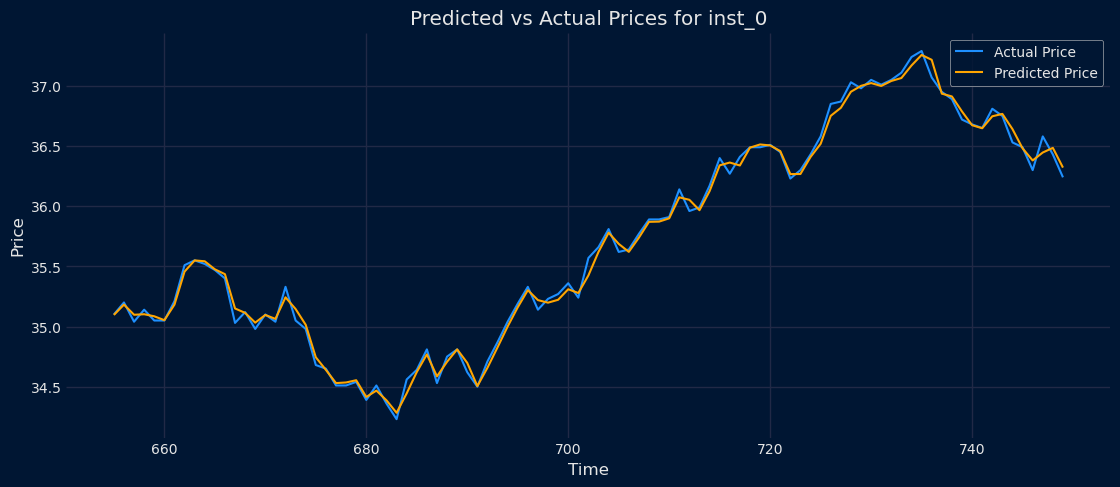

In [16]:
plotPredictedVsActual(predictions_ms_greeks, "inst_0")

# Now to try and predict log returns instead of prices:

In [17]:
logReturns_np = np.load("./greeks/greeksData/LogReturns_lookback=1_750_day_data.npy")
logReturns = pd.DataFrame(logReturns_np)

logReturns.columns = [f"inst_{i}" for i in range(logReturns.shape[1])]

print(f"{colourOrangeBold}Log returns shape = {colourReset}{logReturns.shape}")

Log returns shape = (750, 50)


Create exogenous data (now without log returns and with prices)

In [18]:
greeksFilePaths = sorted(glob.glob("./greeks/greeksData/*.npy"))
greeksFilePaths = [f for f in greeksFilePaths if "LogReturns" not in f]

feature_names = [os.path.splitext(os.path.basename(f))[0] for f in greeksFilePaths]

exog_array = np.stack([np.load(f) for f in greeksFilePaths], axis=-1)  # shape = (750, 50, num_features)

price_data = data
price_array = price_data.to_numpy()

exog_array_with_price = np.concatenate(
    [exog_array, price_array[:, :, np.newaxis]],  # add price as last feature
    axis=-1
)
feature_names.append("price")

exog_dict_for_logReturns = {
    f"inst_{i}": pd.DataFrame(exog_array_with_price[:, i, :], columns=feature_names)
    for i in range(exog_array.shape[1])
}

print(f"{colourOrangeBold}Built exog_dict_for_logReturns with {len(exog_dict_for_logReturns)} instruments, each shape{colourReset} {exog_dict_for_logReturns['inst_0'].shape}")
print("Features:", feature_names)


Built exog_dict_for_logReturns with 50 instruments, each shape (750, 7)
Features: ['Momentum_windowSize=14_750_day_data', 'Momentum_windowSize=3_750_day_data', 'Momentum_windowSize=7_750_day_data', 'Volatility_windowSize=10_750_day_data', 'Volatility_windowSize=20_750_day_data', 'Volatility_windowSize=5_750_day_data', 'price']


Now split our data

In [19]:
logReturns_train = data.loc[TRAIN_START:TRAIN_END - 1].copy()
logReturns_val   = data.loc[TRAIN_END:VAL_END - 1].copy()
logReturns_test  = data.loc[VAL_END:].copy()

print(f"Train days      : {logReturns_train.index.min()} --- {logReturns_train.index.max()}  (n={len(logReturns_train)})")
print(f"Validation days : {logReturns_val.index.min()} --- {logReturns_val.index.max()}  (n={len(logReturns_val)})")
print(f"Test days       : {logReturns_test.index.min()} --- {logReturns_test.index.max()}  (n={len(logReturns_test)})")

Train days      : 20 --- 599  (n=580)
Validation days : 600 --- 674  (n=75)
Test days       : 675 --- 749  (n=75)


In [20]:
exog_dict_for_logReturns["inst_0"]

,Momentum_windowSize=14_750_day_data,Momentum_windowSize=3_750_day_data,Momentum_windowSize=7_750_day_data,Volatility_windowSize=10_750_day_data,Volatility_windowSize=20_750_day_data,Volatility_windowSize=5_750_day_data,price
0,NaN,NaN,NaN,NaN,NaN,NaN,38.25
1,NaN,NaN,NaN,NaN,NaN,NaN,38.11
2,NaN,-0.009192,NaN,NaN,NaN,NaN,37.90
3,NaN,-0.016076,NaN,NaN,NaN,NaN,37.64
4,NaN,-0.010817,NaN,NaN,NaN,0.003717,37.70
...,...,...,...,...,...,...,...
745,-0.014150,-0.008731,-0.010902,0.002907,0.003061,0.004247,36.49
746,-0.020451,-0.012320,-0.011504,0.003102,0.003231,0.002484,36.30
747,-0.014385,0.001368,-0.002730,0.004479,0.003598,0.006276,36.58
748,-0.021991,-0.001646,-0.006021,0.004429,0.003683,0.005845,36.43


Now create this prediction model

In [21]:
forecaster_ms_greeks_logReturns = ForecasterRecursiveMultiSeries(
    regressor           = GradientBoostingRegressor(random_state=8523),
    lags                = 20,
    transformer_series  = None,
    transformer_exog    = StandardScaler(),  # Standardise the Greek features
)

cv = TimeSeriesFold(
    initial_train_size = len(logReturns_train) + len(logReturns_val),
    steps              = 1,
    refit              = True
)

# Backtest
multi_series_mse_greeks_logReturns, predictions_ms_greeks_logReturns = backtesting_forecaster_multiseries(
    forecaster = forecaster_ms_greeks_logReturns,
    series     = logReturns,
    exog       = exog_dict_for_logReturns,
    levels     = list(logReturns.columns),
    cv         = cv,
    metric     = "mean_squared_error"
)

display(multi_series_mse_greeks_logReturns.head())
display(predictions_ms_greeks_logReturns.head())

multi_series_mse_greeks_logReturns = multi_series_mse_greeks_logReturns.rename(columns={"mean_squared_error": "multi_series_mse_greeks_logReturns"})
predictions_ms_greeks_logReturns = predictions_ms_greeks_logReturns.reset_index()
predictions_ms_greeks_logReturns = predictions_ms_greeks_logReturns.rename(columns={"index": "time"})

╭──────────────────────────────── LongTrainingWarning ─────────────────────────────────╮
│ The forecaster will be fit 95 times. This can take substantial amounts of time. If   │
│ not feasible, try with `refit = False`.                                              │
│                                                                                      │
│                                                                                      │
│ Category : LongTrainingWarning                                                       │
│ Location :                                                                           │
│ C:\Users\jense\anaconda3\envs\Algothon-2025\Lib\site-packages\skforecast\model_selec │
│ tion\_validation.py:844                                                              │
│ Suppress : warnings.simplefilter('ignore', category=LongTrainingWarning)             │
╰──────────────────────────────────────────────────────────────────────────────────────╯

  0%|          | 0/95 [00:00<?, ?it/s]

,levels,mean_squared_error
0,inst_0,7.328829e-07
1,inst_1,1.076140e-06
2,inst_2,1.261462e-05
3,inst_3,5.533158e-06
4,inst_4,1.504590e-06


,level,pred
655,inst_0,0.002198
655,inst_1,0.000972
655,inst_2,-0.006105
655,inst_3,-0.001815
655,inst_4,-0.003058


And now plot our predicted log returns against the actual:

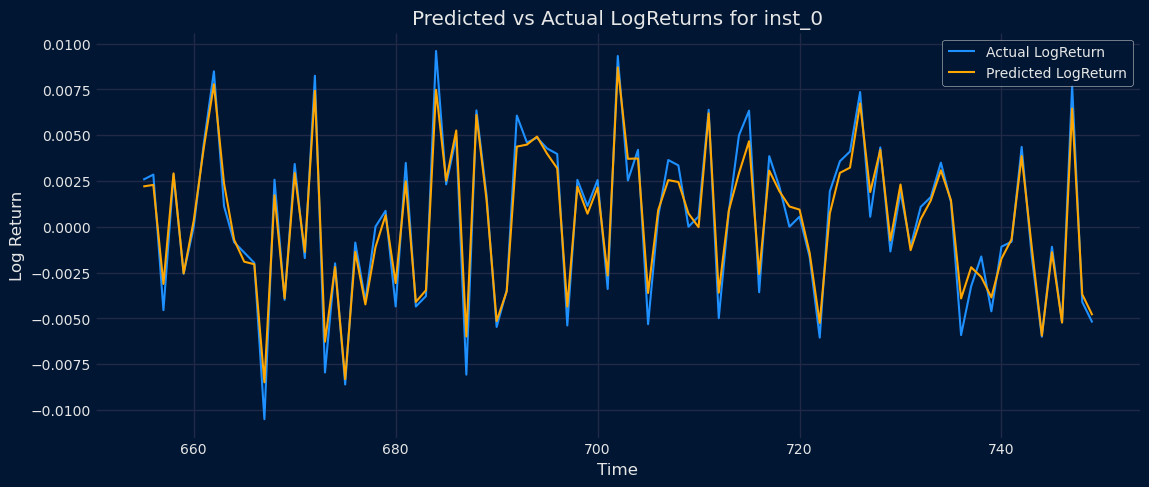

,time,level,pred
0,655,inst_0,0.002198
1,655,inst_1,0.000972
2,655,inst_2,-0.006105
3,655,inst_3,-0.001815
4,655,inst_4,-0.003058
...,...,...,...
4745,749,inst_45,0.002824
4746,749,inst_46,0.004347
4747,749,inst_47,-0.001710
4748,749,inst_48,-0.002832


In [121]:
def plotPredictedVsActualLogReturns(predictions_input, instrument):
    df_preds = predictions_input.copy().rename(columns={"index": "time"})
    df_inst_preds = df_preds[df_preds["level"] == instrument]
    days_predicted = df_inst_preds["time"]
    df_actual = logReturns[[instrument]].copy()
    df_actual["time"] = df_actual.index
    df_actual = df_actual.rename(columns={instrument: "actual"})
    df_actual = df_actual[df_actual["time"].isin(days_predicted)]
    df_plot = df_inst_preds.merge(df_actual, on="time")

    plt.figure(figsize=(12, 5))
    plt.plot(df_plot["time"], df_plot["actual"], label="Actual LogReturn", color='dodgerblue')
    plt.plot(df_plot["time"], df_plot["pred"], label="Predicted LogReturn", color='orange')
    plt.title(f"Predicted vs Actual LogReturns for {instrument}")
    plt.xlabel("Time")
    plt.ylabel("Log Return")
    plt.legend()
    plt.grid(True)
    plt.show()

plotPredictedVsActualLogReturns(predictions_ms_greeks_logReturns, "inst_0")

Convert predicted log returns to be the predicted next price. We can then compare this logReturns predicting model against our pricePredicting model/s

In [23]:
price_predict_from_logReturns = predictions_ms_greeks_logReturns.copy()

# Rename predicted log return column temporarily
price_predict_from_logReturns = price_predict_from_logReturns.rename(columns={"pred": "predicted_logReturn"})

# Reconstruct predicted price using previous day's actual price
def reconstruct_price(row):
    instrument = row['level']
    time = row['time']
    if time == 0:
        return np.nan  # Can't compute for first day
    prev_price = data.loc[time - 1, instrument]
    log_return = row['predicted_logReturn']
    return prev_price * np.exp(log_return)

# Apply the function to reconstruct price
price_predict_from_logReturns["pred"] = price_predict_from_logReturns.apply(reconstruct_price, axis=1)

# Drop the original log return prediction
price_predict_from_logReturns = price_predict_from_logReturns.drop(columns=["predicted_logReturn"])

display(price_predict_from_logReturns)

,time,level,pred
0,655,inst_0,35.087047
1,655,inst_1,54.272730
2,655,inst_2,39.706845
3,655,inst_3,33.928375
4,655,inst_4,45.719985
...,...,...,...
4745,749,inst_45,30.897131
4746,749,inst_46,86.796445
4747,749,inst_47,15.723096
4748,749,inst_48,80.571470


Compare

In [24]:
from sklearn.metrics import mean_squared_error

# Add actual prices from your price DataFrame (`data`)
price_predict_from_logReturns["actual"] = price_predict_from_logReturns.apply(
    lambda row: data.loc[row["time"], row["level"]],
    axis=1
)

predictions_ms_greeks["actual"] = predictions_ms_greeks.apply(
    lambda row: data.loc[row["time"], row["level"]],
    axis=1
)

mse_logReturns = price_predict_from_logReturns.groupby("level", group_keys=False).apply(
    lambda g: mean_squared_error(g["actual"], g["pred"]),
    include_groups=False
).reset_index(name="mse_logReturns")

mse_greeks = predictions_ms_greeks.groupby("level", group_keys=False).apply(
    lambda g: mean_squared_error(g["actual"], g["pred"]),
    include_groups=False
).reset_index(name="mse_greeks")

# Merge and compute improvements
mse_comparison = pd.merge(mse_logReturns, mse_greeks, on="level")
mse_comparison["improvement"] = mse_comparison["mse_greeks"] - mse_comparison["mse_logReturns"]
mse_comparison["improvement_(%)"] = 100 * mse_comparison["improvement"] / mse_comparison["mse_logReturns"]
mse_comparison = mse_comparison.round(4)

# Style output
display(mse_comparison.set_index("level").style.bar(
    subset=["improvement_(%)"], align="mid", color=["#d65f5f", "#5fba7d"]
))

# Summary stats
display(mse_comparison[["improvement", "improvement_(%)"]].agg(["mean", "min", "max"]))


,mse_logReturns,mse_greeks,improvement,improvement_(%)
level,,,,
inst_0,0.000900,0.003000,0.002000,219.027800
inst_1,0.003100,0.008900,0.005900,192.122400
inst_10,0.005800,0.003500,-0.002300,-40.370800
inst_11,0.028800,0.053500,0.024700,85.783100
inst_12,0.008400,0.011400,0.003000,35.947800
inst_13,0.004700,0.004900,0.000300,5.702900
inst_14,0.030500,0.074700,0.044300,145.222600
inst_15,0.003300,0.022400,0.019200,589.164000
inst_16,0.007400,0.064200,0.056800,765.386900


,improvement,improvement_(%)
mean,0.03625,549.08844
min,-0.01970,-52.80040
max,0.30320,3807.53340


Mostly big improvements from predicting prices to predicting log returns.


Having the model retrain every time will exceed the 10 minute running length in the competition, we need to modify. A few options:
- Change the regressor to HistGradientBoostingRegressor
- Turn off refit
- Somehow change refit to not refit everytime but instead every nth time

HIST GRADIENT BOOSTING:

In [25]:
forecaster_ms_greeks_logReturns_hgbr = ForecasterRecursiveMultiSeries(
    regressor           = HistGradientBoostingRegressor(random_state=8523),
    lags                = 20,
    transformer_series  = None,
    transformer_exog    = StandardScaler(),  # Standardise the Greek features
)

cv = TimeSeriesFold(
    initial_train_size = len(logReturns_train) + len(logReturns_val),
    steps              = 1,
    refit              = True
)

# Backtest
multi_series_mse_greeks_logReturns_hgbr, predictions_ms_greeks_logReturns_hgbr = backtesting_forecaster_multiseries(
    forecaster = forecaster_ms_greeks_logReturns_hgbr,
    series     = logReturns,
    exog       = exog_dict_for_logReturns,
    levels     = list(logReturns.columns),
    cv         = cv,
    metric     = "mean_squared_error"
)

display(multi_series_mse_greeks_logReturns_hgbr.head())
display(predictions_ms_greeks_logReturns_hgbr.head())

multi_series_mse_greeks_logReturns_hgbr = multi_series_mse_greeks_logReturns_hgbr.rename(columns={"mean_squared_error": "multi_series_mse_greeks_logReturns_hgbr"})
predictions_ms_greeks_logReturns_hgbr = predictions_ms_greeks_logReturns_hgbr.reset_index()
predictions_ms_greeks_logReturns_hgbr = predictions_ms_greeks_logReturns_hgbr.rename(columns={"index": "time"})

╭──────────────────────────────── LongTrainingWarning ─────────────────────────────────╮
│ The forecaster will be fit 95 times. This can take substantial amounts of time. If   │
│ not feasible, try with `refit = False`.                                              │
│                                                                                      │
│                                                                                      │
│ Category : LongTrainingWarning                                                       │
│ Location :                                                                           │
│ C:\Users\jense\anaconda3\envs\Algothon-2025\Lib\site-packages\skforecast\model_selec │
│ tion\_validation.py:844                                                              │
│ Suppress : warnings.simplefilter('ignore', category=LongTrainingWarning)             │
╰──────────────────────────────────────────────────────────────────────────────────────╯

  0%|          | 0/95 [00:00<?, ?it/s]

,levels,mean_squared_error
0,inst_0,2.852826e-07
1,inst_1,4.885039e-07
2,inst_2,4.842359e-06
3,inst_3,1.582525e-06
4,inst_4,6.300950e-07


,level,pred
655,inst_0,0.002200
655,inst_1,0.000824
655,inst_2,-0.006154
655,inst_3,-0.001837
655,inst_4,-0.003713


Compare HGBR to GBR (just using their log returns mse from now on because we will be predicting log returns)
:

In [26]:
def compareModelToBaseline(new_model_mse):
    # Join them
    results_greeks = pd.merge(
        multi_series_mse_greeks_logReturns,
        new_model_mse,
        left_on="levels",
        right_on="levels",
    )
    # Rename for clarity
    results_greeks.columns = ["level", "GBR_MSE", "NEW_MSE"]
    # Calculate improvement of HGBR over GBR
    results_greeks["improvement"] = results_greeks["NEW_MSE"] - results_greeks["GBR_MSE"]
    results_greeks["improvement_(%)"] = 100 * results_greeks["improvement"] / results_greeks["GBR_MSE"]
    # Round and display
    results_greeks = results_greeks.round(4)
    display(results_greeks.style.bar(subset=['improvement_(%)'], align='mid', color=['#d65f5f', '#5fba7d']))
    display(results_greeks[['improvement', 'improvement_(%)']].agg(['mean', 'min', 'max']))


compareModelToBaseline(multi_series_mse_greeks_logReturns_hgbr)

,level,GBR_MSE,NEW_MSE,improvement,improvement_(%)
0,inst_0,0.000000,0.000000,-0.000000,-61.073900
1,inst_1,0.000000,0.000000,-0.000000,-54.605900
2,inst_2,0.000000,0.000000,-0.000000,-61.613100
3,inst_3,0.000000,0.000000,-0.000000,-71.399200
4,inst_4,0.000000,0.000000,-0.000000,-58.121800
5,inst_5,0.000000,0.000000,-0.000000,-67.592200
6,inst_6,0.000000,0.000000,-0.000000,-73.853000
7,inst_7,0.000000,0.000000,-0.000000,-79.351400
8,inst_8,0.000000,0.000000,-0.000000,-66.255600
9,inst_9,0.000000,0.000000,-0.000000,-82.253000


,improvement,improvement_(%)
mean,0.0,-70.082796
min,-0.0,-85.209000
max,-0.0,-51.838100


Now a model without refit


In [27]:
forecaster_ms_greeks_logReturns = ForecasterRecursiveMultiSeries(
    regressor           = GradientBoostingRegressor(random_state=8523),
    lags                = 20,
    transformer_series  = None,
    transformer_exog    = StandardScaler(),  # Standardise the Greek features
)

cv = TimeSeriesFold(
    initial_train_size = len(logReturns_train) + len(logReturns_val),
    steps              = 1,
    refit              = False
)

# Backtest
multi_series_mse_greeks_logReturns_noRefit, predictions_ms_greeks_logReturns_noRefit = backtesting_forecaster_multiseries(
    forecaster = forecaster_ms_greeks_logReturns,
    series     = logReturns,
    exog       = exog_dict_for_logReturns,
    levels     = list(logReturns.columns),
    cv         = cv,
    metric     = "mean_squared_error"
)

display(multi_series_mse_greeks_logReturns_noRefit.head())
display(predictions_ms_greeks_logReturns_noRefit.head())

multi_series_mse_greeks_logReturns_noRefit = multi_series_mse_greeks_logReturns_noRefit.rename(columns={"mean_squared_error": "multi_series_mse_greeks_logReturns_noRefit"})
predictions_ms_greeks_logReturns_noRefit = predictions_ms_greeks_logReturns_noRefit.reset_index()
predictions_ms_greeks_logReturns_noRefit = predictions_ms_greeks_logReturns_noRefit.rename(columns={"index": "time"})

  0%|          | 0/95 [00:00<?, ?it/s]

,levels,mean_squared_error
0,inst_0,6.627241e-07
1,inst_1,1.008866e-06
2,inst_2,1.170937e-05
3,inst_3,6.404734e-06
4,inst_4,1.288826e-06


,level,pred
655,inst_0,0.002198
655,inst_1,0.000972
655,inst_2,-0.006105
655,inst_3,-0.001815
655,inst_4,-0.003058


Compare this to the best model:

In [28]:
compareModelToBaseline(multi_series_mse_greeks_logReturns_noRefit)

,level,GBR_MSE,NEW_MSE,improvement,improvement_(%)
0,inst_0,0.000000,0.000000,-0.000000,-9.573000
1,inst_1,0.000000,0.000000,-0.000000,-6.251400
2,inst_2,0.000000,0.000000,-0.000000,-7.176200
3,inst_3,0.000000,0.000000,0.000000,15.751900
4,inst_4,0.000000,0.000000,-0.000000,-14.340400
5,inst_5,0.000000,0.000000,-0.000000,-3.271100
6,inst_6,0.000000,0.000000,0.000000,10.037700
7,inst_7,0.000000,0.000000,0.000000,5.291000
8,inst_8,0.000000,0.000000,0.000000,1.640800
9,inst_9,0.000000,0.000000,0.000000,16.813100


,improvement,improvement_(%)
mean,0.0,0.054255
min,0.0,-26.431500
max,0.0,20.049400


Basically the same (but here we have 95 days of data not being considered with refit = False, in the competition it will be 250)
time to train ~ 30 seconds
So far, this is the best thing to use in our submission


# HyperParameterTuning

### To get the most out of our model, tune the params.

Params to tune:
- Lags
- Learning Rate
- max_depth (max depth of tree in the ensemble) # Decided to not do
- max_iter (number of trees in the ensemble) # Decided to not do

In [109]:
def search_space(trial):
    return {
        'lags': trial.suggest_categorical('lags', [7, 14, 21, 28, 35]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
    }

In [110]:
forecaster_ms_tuning = ForecasterRecursiveMultiSeries(
    # Using HGBR because of the speed for training. Results should be transferable to GBR model for actual submission
    regressor           = HistGradientBoostingRegressor(random_state=8523),
    lags                = 20, # Should be overwritten by the search space
    transformer_exog    = StandardScaler(),
    transformer_series  = None,
    encoding            = 'ordinal'
)

cv_search = TimeSeriesFold(
    initial_train_size  = len(logReturns_train) + len(logReturns_val),
    steps               = 1,
    refit               = False
)

In [111]:
# For bayesian search we need to change the shape of our exogs
def flatten_exog_dict_to_wide_df(exog_dict):
    dfs = []
    for level, df in exog_dict.items():
        renamed = df.copy()
        renamed.columns = [f"{level}__{col}" for col in df.columns]
        dfs.append(renamed)

    # All have same number of rows, so just concat by columns
    return pd.concat(dfs, axis=1)

# Apply it
exog_wide = flatten_exog_dict_to_wide_df(exog_dict_for_logReturns)
print("exog_wide.shape:", exog_wide.shape)  # Should be (750, many columns)


exog_wide.shape: (750, 350)


Bayesian search for hyper param tuning


In [112]:
from skforecast.model_selection import bayesian_search_forecaster_multiseries
from skforecast.exceptions import OneStepAheadValidationWarning
from skforecast.exceptions import MissingValuesWarning

warnings.simplefilter("ignore", category=OneStepAheadValidationWarning)
warnings.simplefilter("ignore", category=MissingValuesWarning)
forecaster_ms_tuning.dropna_from_series = True

results_df, best_trial = bayesian_search_forecaster_multiseries(
    forecaster      = forecaster_ms_tuning,
    series          = logReturns,
    levels          = None,  # All instruments
    exog            = exog_wide,
    cv              = cv_search,
    search_space    = search_space,
    n_trials        = 40,
    metric          = 'mean_squared_error',
    return_best     = True, #results_bayesion will contain the best fitting forecaster, params and metrics.
    show_progress   = True,
)

print(type(results_df))
print(type(best_trial))

best_idx = results_df['mean_squared_error__weighted_average'].idxmin()
best_row = results_df.loc[best_idx]

print("Best Trial Index:", best_idx)
print("Best Params:", best_row['params'])
print("Best Lags:", best_row['lags'])
print("Best MSE:", best_row['mean_squared_error__weighted_average'])

  0%|          | 0/100 [00:00<?, ?it/s]

╭──────────────────────────────── MissingValuesWarning ────────────────────────────────╮
│ NaNs detected in `X_train`. They have been dropped. If you want to keep them, set    │
│ `forecaster.dropna_from_series = False`. Same rows have been removed from `y_train`  │
│ to maintain alignment. This caused by series with interspersed NaNs.                 │
│                                                                                      │
│ Category : MissingValuesWarning                                                      │
│ Location :                                                                           │
│ C:\Users\jense\anaconda3\envs\Algothon-2025\Lib\site-packages\skforecast\recursive\_ │
│ forecaster_recursive_multiseries.py:1204                                             │
│ Suppress : warnings.simplefilter('ignore', category=MissingValuesWarning)            │
╰──────────────────────────────────────────────────────────────────────────────────────╯

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'learning_rate': 0.08402777585559944}
  Backtesting metric: 9.13075514821221e-05
  Levels: ['inst_0', 'inst_1', 'inst_2', 'inst_3', 'inst_4', 'inst_5', 'inst_6', 'inst_7', 'inst_8', 'inst_9', '...', 'inst_40', 'inst_41', 'inst_42', 'inst_43', 'inst_44', 'inst_45', 'inst_46', 'inst_47', 'inst_48', 'inst_49']

<class 'pandas.core.frame.DataFrame'>
<class 'optuna.trial._frozen.FrozenTrial'>
Best Trial Index: 0
Best Params: {'learning_rate': 0.08402777585559944}
Best Lags: [1 2 3 4 5 6 7]
Best MSE: 9.13075514821221e-05


In [122]:
best_params = best_row['params']
best_lags = best_row['lags']

best_params_for_gbr = {"learning_rate": best_params["learning_rate"]}

best_forecaster = ForecasterRecursiveMultiSeries(
    regressor = GradientBoostingRegressor(**best_params_for_gbr),
    transformer_series  = None,
    transformer_exog    = StandardScaler(),
    lags = best_lags,
)

best_forecaster.dropna_from_series = True

cv = TimeSeriesFold(
    initial_train_size  =len(logReturns_train) + len(logReturns_val),
    steps               =1,
    refit               =False
)

multi_series_mse_tuned, predictions_tuned = backtesting_forecaster_multiseries(
    forecaster  = best_forecaster,
    series      = logReturns,
    exog        = exog_dict_for_logReturns,
    levels      = list(logReturns.columns),
    cv          = cv,
    metric      = 'mean_squared_error',
)

multi_series_mse_tuned = multi_series_mse_tuned.rename(columns={"mean_squared_error": "multi_series_mse_tuned"})
predictions_tuned = predictions_tuned.reset_index()
predictions_tuned = predictions_tuned.rename(columns={"index": "time"})

╭──────────────────────────────── MissingValuesWarning ────────────────────────────────╮
│ NaNs detected in `X_train`. They have been dropped. If you want to keep them, set    │
│ `forecaster.dropna_from_series = False`. Same rows have been removed from `y_train`  │
│ to maintain alignment. This caused by series with interspersed NaNs.                 │
│                                                                                      │
│ Category : MissingValuesWarning                                                      │
│ Location :                                                                           │
│ C:\Users\jense\anaconda3\envs\Algothon-2025\Lib\site-packages\skforecast\recursive\_ │
│ forecaster_recursive_multiseries.py:1204                                             │
│ Suppress : warnings.simplefilter('ignore', category=MissingValuesWarning)            │
╰──────────────────────────────────────────────────────────────────────────────────────╯

  0%|          | 0/95 [00:00<?, ?it/s]

Now compare against our old benchmark:

In [123]:
compareModelToBaseline(multi_series_mse_tuned)

,level,GBR_MSE,NEW_MSE,improvement,improvement_(%)
0,inst_0,0.000000,0.000000,0.000000,26.755600
1,inst_1,0.000000,0.000000,0.000000,40.134100
2,inst_2,0.000000,0.000000,0.000000,29.596200
3,inst_3,0.000000,0.000000,0.000000,66.975600
4,inst_4,0.000000,0.000000,0.000000,19.755200
5,inst_5,0.000000,0.000000,0.000000,27.658300
6,inst_6,0.000000,0.000000,0.000000,54.919700
7,inst_7,0.000000,0.000000,0.000000,54.354200
8,inst_8,0.000000,0.000000,0.000000,40.203800
9,inst_9,0.000000,0.000000,0.000000,44.658300


,improvement,improvement_(%)
mean,0.0,42.49386
min,0.0,10.52680
max,0.0,66.97560


~42% increase after param tuning in a no refit model compared to the initial model with refit.

Plot predicted log returns against actual (and our benchmark too):

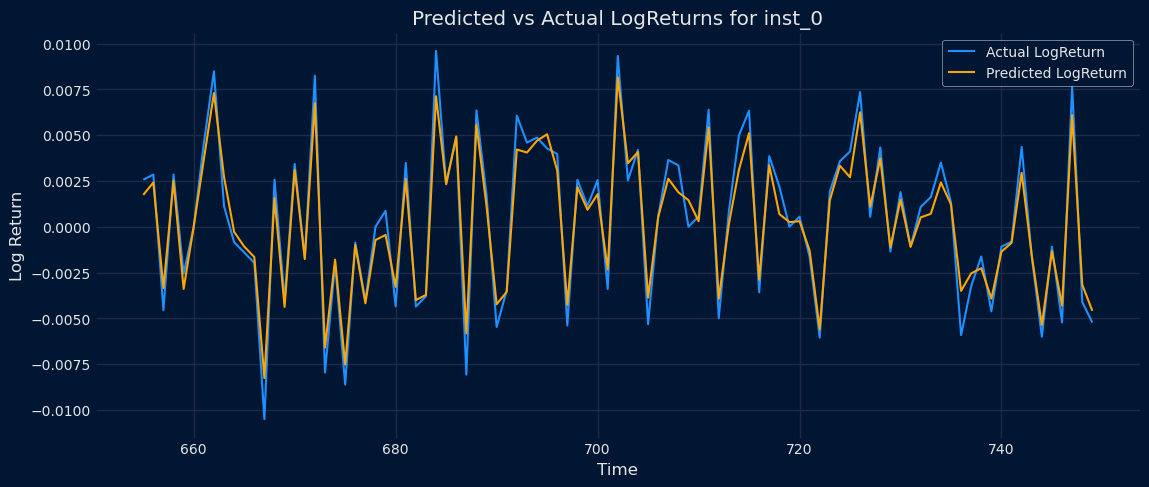

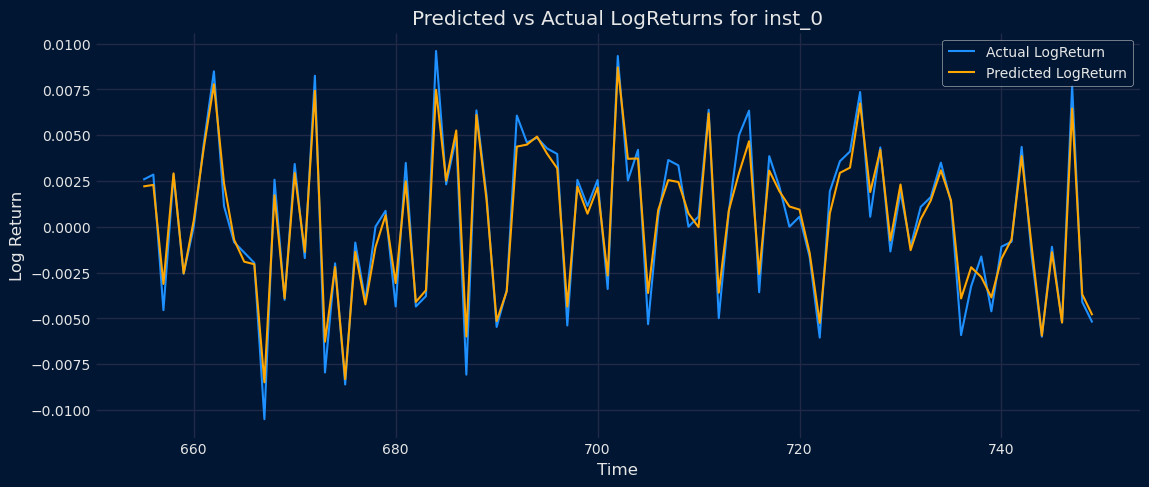

In [127]:
plotPredictedVsActualLogReturns(predictions_tuned, "inst_0")
plotPredictedVsActualLogReturns(predictions_ms_greeks_logReturns, "inst_0")

Cant really tell. Even though the new model has a 42% improvement in the mse, the mse was already so low it doesnt make too much of a difference.

Save our best params to a file:

In [128]:
import joblib
import os
from datetime import datetime

# Create a folder for model saves
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# Save everything as a dictionary
model_package = {
    "forecaster": best_forecaster,
    "best_params": best_params,
    "best_lags": best_lags,
    "transformer_exog": StandardScaler(),  # NOTE: replace with actual fitted scaler if needed
    "timestamp": datetime.now().isoformat()
}

# Save to file
joblib.dump(model_package, os.path.join(save_dir, "forecaster_model.pkl"))

['saved_models\\forecaster_model.pkl']

Some ideas:
- Predict vol over an n window and then steps = n as well to have a predictor of future volatilities of instruments for risk
- Predict log returns with step 2 together with step 1. then if they oppose say next log return is > 0, and the one after is < 0, might be a bad idea to buy because of the trading tax or something